# import dependencies

In [ ]:
# !pip3 install tensorflow matplotlib tensorflow-datasets ipywidgets

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

In [2]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# import tensorflow datasets
import tensorflow_datasets as tfds
# import pyplot
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

# visualize datasets

In [5]:
import numpy as np

In [6]:
#build data iterator in numpy
data_iterator = ds.as_numpy_iterator()

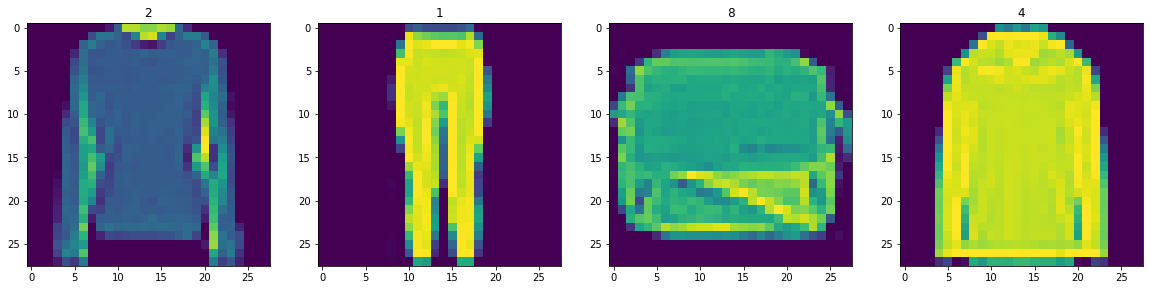

In [7]:
# viz images
# setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    # grab an image and label
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [9]:
# data processing -> scale the value to betweeen 0 - 1 and return the image only
def scale_images(data):
    image = data['image']
    return image / 255

In [10]:
# reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle the dataset
ds = ds.shuffle(60000)
# batch it into 128 images per sample
ds = ds.batch(128)
# reduce the likelihood of bottleneckin
ds = ds.prefetch(64)

# Build Neural Networks

### Import Modeling components

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [31]:
# build generators
def build_generator():
    model = Sequential()

    # takes in random values and reshapes it to 7*7*128
    # beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128)) # the input layer is a Dense fully-connected layer
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [53]:
generator = build_generator()
generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 128)       409728    
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 28, 28, 128)     

### testing generating images without training

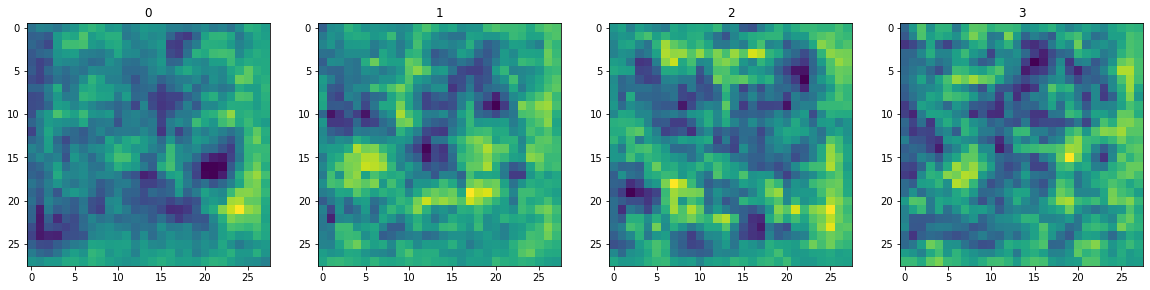

In [54]:
imgs = generator.predict(np.random.randn(4,128))
# visualize the generated test images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(imgs):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### build a discriminator (classifier)

In [42]:
def build_discriminator():
    model = Sequential()
    
    # first conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # third conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # fourth conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # flatten and pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    # 1 for a fake image and 0 for a real image
    model.add(Dense(1, activation='sigmoid'))

    return model

In [43]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 20, 20, 64)        51264     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 128)     

In [46]:
discriminator.predict(np.expand_dims(imgs[3], 0))

array([[0.48573828]], dtype=float32)

# Construct Training Loop

### Set up losses and Optimizers

In [47]:
# use binary cross entropy for both generator and discriminator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [49]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### build subclassed model

In [50]:
# importing the base model class
from tensorflow.keras.models import Model

In [66]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, g_loss, d_opt, d_loss, *args, **kwargs): # call to .fit() 
        # compile the model with the base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.g_loss = g_loss
        self.d_opt = d_opt
        self.d_loss = d_loss
        
        pass
    def train_step(self, batch):
        # get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
    
            # add noise to the output
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply back propagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # train the generator
        with tf.GradientTape() as g_tape:
            # generate some new images
            gen_images = self.generator(tf.random.normal((128, 128)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # calculate losses - trick to training to fake out discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply back propagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss: ": total_d_loss, "g_loss: ": total_g_loss}

In [67]:
# create instance of subclassed model
new_gan = GAN(generator, discriminator)

# compile the new model
new_gan.compile(g_opt, g_loss, d_opt, d_loss)

### build callbacks

In [56]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [69]:
class ModelMonitor(Callback):
    def __init__(self, num_img = 3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### Train

In [70]:
hist = new_gan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
104/469 [=====>........................] - ETA: 39:21 - d_loss: : 0.2859 - g_loss: : 2.3528

KeyboardInterrupt: 